### Light python event model used to simulate Juster events
- liquidity providing risk estimation
- different market maker behaviur testing

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np

from dynamics import calc_dynamics_by_freq
from coinbase_api import CoinbaseAPI
from plot import plot_dynamics_hists


sns.set_style("whitegrid")

In [2]:
import sys
sys.path.insert(0, '../../tests')
from event_model import EventModel

### Getting data to use as source of the price dynamics:

In [3]:
api = CoinbaseAPI()

pair = 'XTZ-USD'
event_durations = [3600, 21600, 86400]

dfs = {
    duration: api.get_history_prices(pair=pair, granularity=duration)
    for duration in event_durations
}

dynamics = {
    duration: calc_dynamics_by_freq(dfs[duration], f'{duration}S')
    for duration in event_durations
}

### Current data distribution:

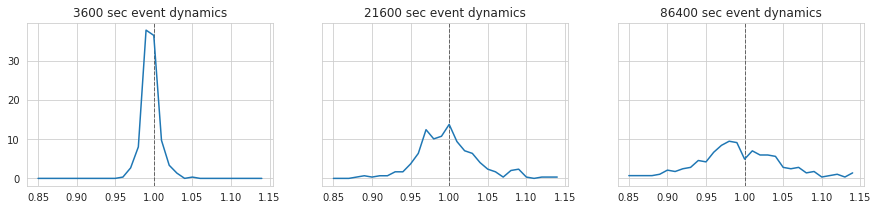

In [6]:
axes = plot_dynamics_hists(dynamics)

In [9]:
from random import random, randint, choice
from types import SimpleNamespace
from tqdm import tqdm

## WIP
### TODO: params generator
### TODO: run emulation
### TODO: save data
### TODO: analyze data
- maybe using dash or another BI? find a way to make it interactive, so it would be easy to calculate mean event results

In [10]:
# this all params should be generated using different distributions
generation_params = dict(
    # total betting length:
    ticks = 1000,

    # users count does not affect chances
    users_count = 10,

    # event duration in seconds, data available for 3600, 21600 and 86400 secs:
    # duration=3600,
    # instead of event duration just func that makes actual_dynamics:
    # lambda: choice(dynamics[3600])
    actual_dynamics = 1.03,
    target_dynamics=1,

    fee=0.03,

    primary_provider_amount=100,

    # make ratio estimation based on market data ratio with some error added:
    primary_provider_ratio_a=1,
    primary_provider_ratio_b=1,
    # ^^ or use one value for all ratios?

    following_provider_amount=100,

    # TODO: make bettor_ratio_tends_to that calculated on market data with some error
    # bettor_ratio_tends_to

    # TODO: bet value should be distributed exponentialy and coef should be addred in params
    bet_mean_value=1,
    bet_lambda=1,

    # chance that one of the users will bet during the tick:
    bet_chance=0.1,

    # TODO: include DAO profit fee somewhere
)



# class EventRunner?
def run_random_event(**args):
    # TODO: decide is this good way to work with params?
    p = SimpleNamespace(**args)

    # creating users:
    users = [f'user_{num}' for num in range(p.users_count)]
    primary_provider = 'primary_provider'
    following_provider = 'following_provider'

    winning_pool = 'aboveEq' if p.actual_dynamics >= p.target_dynamics else 'below'
    event = EventModel(
        fee=p.fee,
        winning_pool=winning_pool
    )

    # TODO: move provided ratio to generation_params + emulate some error to this ratio
    event.provide_liquidity(
        user=primary_provider,
        amount=p.primary_provider_amount,
        pool_a=p.primary_provider_ratio_a,
        pool_b=p.primary_provider_ratio_b
    )

    following_provider_entry_tick = randint(0, p.ticks)

    for tick in range(p.ticks):
        if p.bet_chance > random():
            # TODO: amount to generation_params
            # make normal distributed bet: (mean_bet, sigma)
            bet_amount = p.bet_mean_value
            bet_pool = choice(['aboveEq', 'below'])
            event.bet(
                user=choice(users),
                amount=bet_amount,
                pool=bet_pool,
                time=tick/p.ticks
            )

            # TODO: make that betters tend to market data ratio with some error or without?
            # TODO: how to both have exponential distribution and tending to some value?

        if tick == following_provider_entry_tick:
            event.provide_liquidity(
                user=following_provider,
                amount=p.following_provider_amount
            )

    return event

### Running generation:

In [11]:
%%time
iterations = 1000

results = [
    {
        # TODO: here should be new params generated each call:
        **generation_params,
        **run_random_event(**generation_params).to_dict()
    } for _ in tqdm(range(iterations))
]

df = pd.json_normalize(results)

100%|██████████| 1000/1000 [00:00<00:00, 2400.69it/s]

CPU times: user 490 ms, sys: 10.4 ms, total: 500 ms
Wall time: 530 ms
